Kalman Filter




In [ ]:
# These are the primary assumptions on the quail and the ninjas noise and measurements
import numpy as np
import matplotlib.pyplot as plt


duration = 10.1  # Duration is set to 10.1 so it inlucdes all values between 0 and 10 at a .1 interval
dt = .1          # invterval for time

A = np.array([[1, dt], [0,1]])  # state transition matrix
B = np.array([[(dt**2)/2],[dt]]) # Input control matrix: expected effect of the input accerlation on the state
C = np.array([1,0]) # measurement matrix: expected measurment given predicted state

u = 15   # acceleration magnitude of quail
Q = np.array([[0] ,[0]])  # initial state, postion of quail an velocity


QuailAccel_noise_mag = .5 # variable of how quickly the quail is accelerating at each time point noise
NinjaVision_noise_mag = 10 # added noise to how well the ninja can track
Ez = NinjaVision_noise_mag**2 # covariance of measurment


* The above section is about initializing the different variables that are used to calculate the quail and the ninjas predictions and movements.

*   the duration is set to 10 seconds and is sampled every .1 seconds
*   A is the state transition matrix
*  B is the expected effect of the input on the current state
*  C is expected measurment given a predicted state

* u is how quickly the quial is able to accelerate
* QauilAccel_noise_mag is the variability of the acceleration between each time point
*  NinjaVision_noise_mag is the noise of how poorly the ninja can track. higher value means lower tracking quality



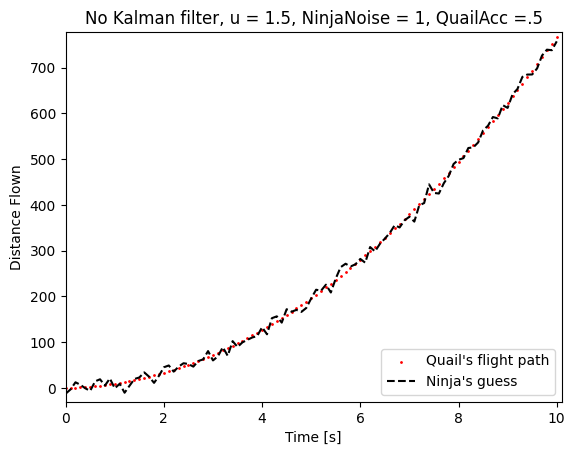

In [ ]:
ele_11 = (QuailAccel_noise_mag**2) * (dt**4 / 4)
ele_12 = (QuailAccel_noise_mag**2) * (dt**3 / 2)
ele_21 = (QuailAccel_noise_mag**2) * (dt**3 / 2)
ele_22 = (QuailAccel_noise_mag**2) * (dt**2)

# Create the matrix Ex
Ex = np.array([[ele_11, ele_12], [ele_21, ele_22]])
P = Ex # initial quail position

Q_loc = [] # actual quail path
vel = [] # actual quial velocity
Q_loc_meas = [] # what ninja sees

time = np.arange(0,duration, dt) # time steps

for t in time:
    # Generate the Quail flight
    QuailAccel_noise = QuailAccel_noise_mag * np.array([(dt**2/2)*np.random.randn(), dt*np.random.randn()]).reshape(-1, 1)
    Q = np.dot(A, Q) + np.dot(B, u) + QuailAccel_noise

    # Generate what the Ninja sees
    NinjaVision_noise = NinjaVision_noise_mag * np.random.randn()
    y = np.dot(C, Q) + NinjaVision_noise

    # Append values to the lists
    Q_loc.extend(Q[0])
    Q_loc_meas.extend(y)
    vel.extend(Q[1])



# Plot and make it look nice
plt.axis([0, duration, -30, Q_loc[-1] + 10])
plt.scatter(time, Q_loc,color = 'red', s = 1)
plt.plot(time,Q_loc_meas,color = 'black', linestyle = '--')
plt.xlabel('Time [s]')
plt.ylabel('Distance Flown')
plt.legend(["Quail's flight path", "Ninja's guess"], loc = 'lower right')
plt.title("No Kalman filter, u = 1.5, NinjaNoise = 1, QuailAcc =.5")
plt.show()

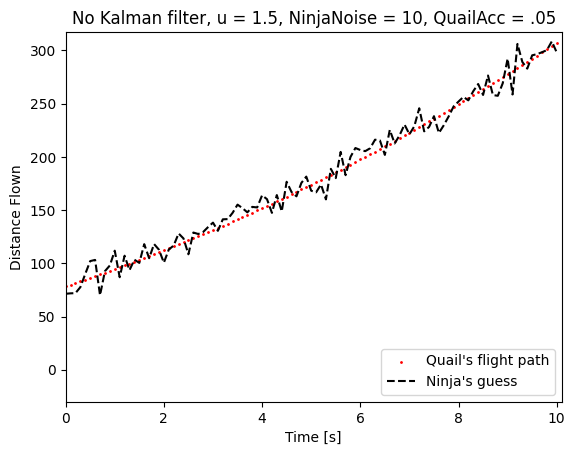

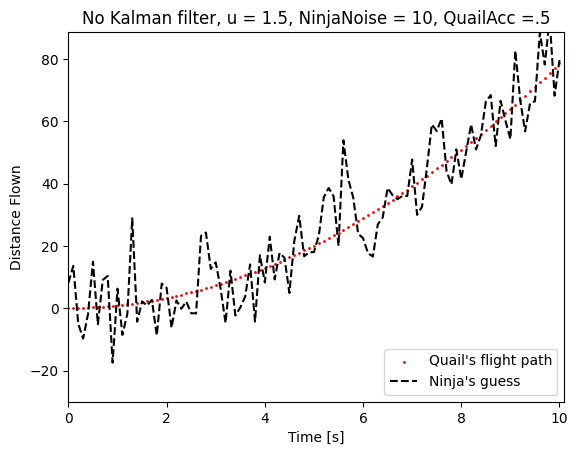

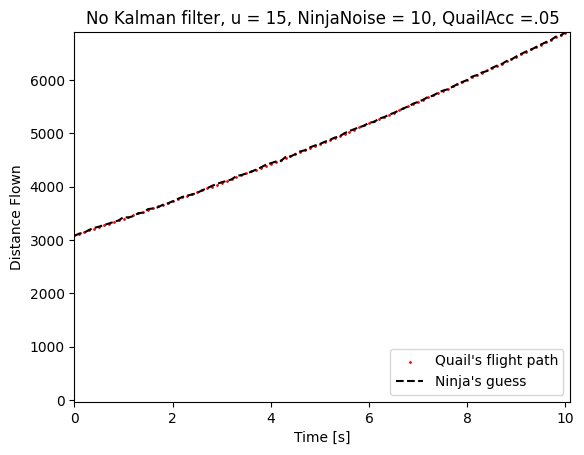



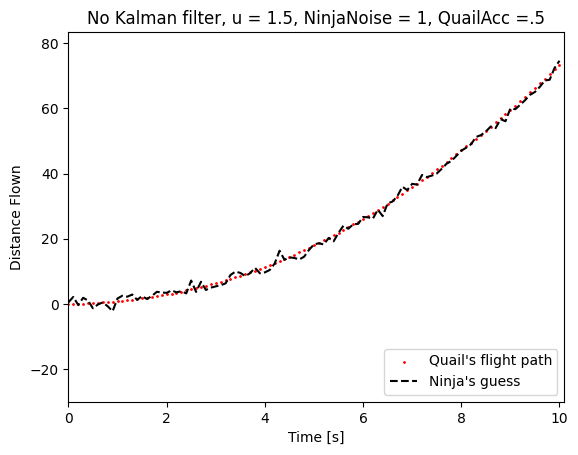



Increasing the Ninja noise increase the noise in the ninjas ability to accurately track the quail.
Increasing the u allows the quail to fly away further in the samme amount of time. By increasing the Quail Acc it increases the noise and variabilyt between each time point. Meaning that between each time point the quails velocity varies more greatly

We are using our state prediction which is Xt = AXt-1 + Bu + Ex and our state measurment Zt = CXt + Ez. Our state is made up of 2 components, Position and Velocity. In the above section we use the kinematic equations for finding the position and velocity to help us predict what the next state will be. Whjch gives us our A, B, C matricies. Using the Kalman filter algorithm we have our  state prediction plus the Kalman gain multiplied by the correction which is the difference between the state measurement and state prediction. The Kalman gain determines how much an effect the correction has on the state prediction. The Kalman gain is calculated as Pt-1*C'(C*Pt-1*C' + Ez)^-1. P is the prior states covariance, C is the expected measurent and Ez is the covariance of the noise matrix.

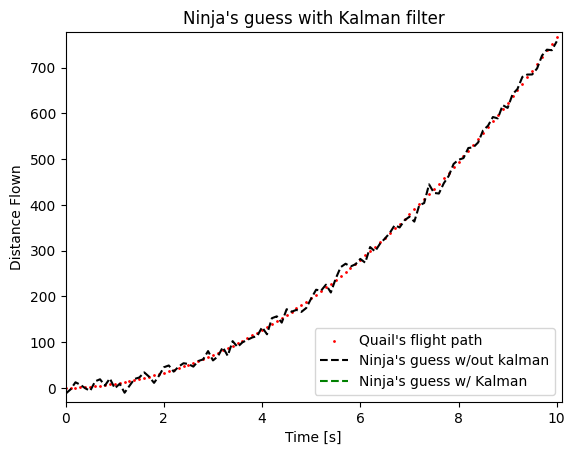

In [ ]:
Q_estimate = Q  # estimate of initial location of quail
Q_loc_estimate = []
vel_estimate = []
Q = np.array([[0] ,[0]])
P_estimate = P
P_mag_estimate = []
predic_state = []
predic_var = []
CT = np.array([[1],[0]])

for t in range(len(Q_loc)):

  # PRedict the next state of the quail with last state and predicted movement
  Q_estimate = np.dot(A, Q_estimate) + np.dot(B, u)
  predic_state.extend(Q_estimate[0])

  # predict next covariance
  P = np.dot(np.dot(A, P), np.transpose(A)) + Ex
  predic_var.extend(P)

  # Kalman Gain calculation
  K1 = np.dot(P, CT)
  K2 = 1/(np.dot(np.dot(C,P), CT) + Ez)
  K3 = np.dot(K1,K2)
  K = np.array([[K3[0]],[K3[1]]])

  # update the state estimate
  filler = Q_loc_meas[t] - np.dot(C,Q_estimate)
  Q_estimate = Q_estimate + K * filler

  # update covariance estimate
  P = np.dot((np.eye(2,2) - (K*C)),P)

  Q_loc_estimate.extend(Q_estimate[0])
  vel_estimate.extend(Q_estimate[1])
  P_mag_estimate.extend(P[0])


plt.scatter(time, Q_loc, color = 'red', s = 1)
plt.plot(time,Q_loc_meas, color = 'black', linestyle = '--')
plt.plot(time,Q_loc_estimate, color = 'green', linestyle = '--')
plt.axis([0, duration, -30, Q_loc[-1] + 10])
plt.xlabel('Time [s]')
plt.ylabel('Distance Flown')
plt.legend(["Quail's flight path", "Ninja's guess w/out kalman", "Ninja's guess w/ Kalman"], loc = 'lower right')
plt.title("Ninja's guess with Kalman filter")
plt.show()

By adding the kalman filter the ninja is able to track the quail significantly better than before. The ninja almost immediatly is able to follow the path with a high degree of accuracy

In [ ]:
from scipy.stats import norm

# Plots the evolution of the distribution
#def normpdf(x, mu, sigma):
  # return 1/(sigma*np.sqrt(2*np.pi))*np.exp(-1*(x-mu)**2/ (2*sigma**2) )


for t in range(len(Q_loc_estimate)):

  x = np.arange(Q_loc_estimate[t] - 5, Q_loc_meas[t] + 5, .1)

  # predict the next postion of the quail
  mu = predic_state[t]
  sigma = predic_var[t][0]
  y = norm.pdf(x, mu, sigma)
  y = y/np.max(y)
  plt.plot(x, y, color = 'black')


  # Data measured by ninja
  mu_n = Q_loc_meas[t]
  sigma_n = NinjaVision_noise_mag
  y_n = norm.pdf(x, mu_n, sigma_n)
  y_n = y_n/np.max(y_n)
  plt.plot(x, y_n, color = 'red')


  # Combined postion estimate
  mu_c = Q_loc_estimate[t]
  sigma_c = P_mag_estimate[t]
  y_c = norm.pdf(x, mu_c, sigma_c)
  y_c = y_c/np.max(y_c)
  plt.plot(x, y_c, color = 'green')
  plt.axis([Q_loc_estimate[t]-5, Q_loc_estimate[t]+5, 0,1])

  # Actual postion of quail
  ylim = plt.gca()
  plt.plot(Q_loc[t], color = 'blue')
  plt.legend(['State Prediction', 'Measurement', 'State Estimate', 'Actual Position'])
  plt.show()
  plt.close('all')

#plt.plot(x, y, color = 'black')
#plt.plot(x, y_n, color = 'red')
#plt.plot(x, y_c, color = 'green')
#plt.plot(Q_loc[t], color = 'blue')
#




ValueError: ignored